# Performance of the Circuit

Let's see if all the code is working propertly.

In [1]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_coupling_map
from py_functions.error_cal import error
from py_functions.noise_simulation import noise_simulation
from py_functions.ent_matrix import Coupling_Circuit
import numpy as np
from itertools import permutations
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
# Define the same quantum circuit as before.
qc = QuantumCircuit(6,6)
qc.h([0,1,2,3])
qc.ccx(0,3,4)
qc.cx(0,3)
qc.ccx(2,4,5)
qc.cx(2,4)
qc.ccx(1,4,5)
qc.cx(1,4)
qc.draw()

┌───┐                              
q_0: ┤ H ├──■────■──────────────────────
     ├───┤  │    │                      
q_1: ┤ H ├──┼────┼──────────────■────■──
     ├───┤  │    │              │    │  
q_2: ┤ H ├──┼────┼────■────■────┼────┼──
     ├───┤  │  ┌─┴─┐  │    │    │    │  
q_3: ┤ H ├──■──┤ X ├──┼────┼────┼────┼──
     └───┘┌─┴─┐└───┘  │  ┌─┴─┐  │  ┌─┴─┐
q_4: ─────┤ X ├───────■──┤ X ├──■──┤ X ├
          └───┘     ┌─┴─┐└───┘┌─┴─┐└───┘
q_5: ───────────────┤ X ├─────┤ X ├─────
                    └───┘     └───┘     
c: 6/═══════════════════════════════════

We are going to work with the linear coupling map. Nevertheless, the code works for any kind of coupling.

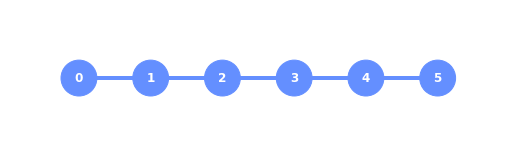

In [3]:
linear_cmap = [[0,1],[1,2],[2,3],[3,4],[4,5]]
plot_coupling_map(6, [[0,0],[0,1],[0,2],[0,3],[0,4],[0,5]] , linear_cmap)

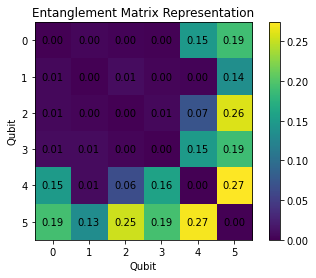

In [4]:
# Lets plot the entanglement matrix.
cmap_matrix = Coupling_Circuit.ent_matrix_final(qc, 10000)
Coupling_Circuit.plot_ent_matrix(cmap_matrix)

The previous matrix suggest that we need to keep together the qubits [5,2], [5,4], [5,3]. Due to we cannot couple three qubits in this architecture, we need to prioritize the coupling with the biggest values.  
Let's construct a coupling map that works with the previous matrix.

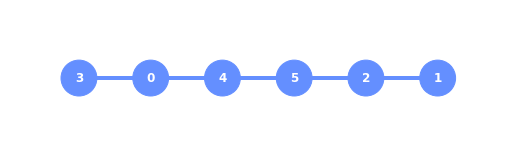

In [6]:
ent_aware_cmap = [[3,0],[0,4],[4,5],[5,2],[1,2]]
plot_coupling_map(6,[[0,1],[0,5],[0,4],[0,0],[0,2],[0,3]], ent_aware_cmap)

For our particular case we are interested in measure the last three qubits (3,4,5) and compare the results from the linear coupling map.

In [7]:
measure_qubits = [3,4,5]
shots = 1024

# Calculate all the dictionaries.
# 1. Perfect dictionary.
qc_exec = qc.copy() # Create an auxiliar quantum circuit to operate.
real_dict = noise_simulation(False, qc_exec, measure_qubits, shots, [])
# 2. Linear noisy dictionary.
qc_exec = qc.copy()
noise_linear_dict = noise_simulation(True, qc_exec, measure_qubits, shots, linear_cmap)
# 3. Entanglement noisy dictionary.
qc_exec = qc.copy()
noise_ent_dict = noise_simulation(True, qc_exec, measure_qubits, shots, ent_aware_cmap)

## Calculate the error between the couplings

In [8]:
error_linear = error(real_dict, noise_linear_dict , shots)
print("The linear error = {}".format(error_linear))

error_ent = error(real_dict, noise_ent_dict , shots)
print("The entanglement-aware error = {}".format(error_ent))

The linear error = 0.203125
The entanglement-aware error = 0.16015625


As we can see the error from the linear is bigger from the entanglement-aware one. This is not always the case, then lets take a sample of 1000 to calculate the mean and the standard desviation of the samples.

In [9]:
error_linear = []
error_ent = []
samples = 2 # 1000
shots = 1024 # For values: 1024, 2048, 4096, 8192, 16384, 131072

for i in range(0,samples):

    print("Executing cycle: {}".format(i))

    qc_exec = qc.copy()
    noise_linear_dict = noise_simulation(True, qc_exec, measure_qubits, shots, linear_cmap)
    error_linear.append(error(real_dict, noise_linear_dict , shots))

    qc_exec = qc.copy()
    noise_ent_dict = noise_simulation(True, qc_exec, measure_qubits, shots, ent_aware_cmap)
    error_ent.append(error(real_dict, noise_ent_dict , shots))

Executing cycle: 0
Executing cycle: 1


For dont bother with running all the circuits let's plot the data that was previously calculated.

In [10]:
error_ent_1024 = np.load("Data/error_ent_1024.npy")
error_linear_1024 = np.load("Data/error_linear_1024.npy")

error_ent_2048 = np.load("Data/error_ent_2048.npy")
error_linear_2048 = np.load("Data/error_linear_2048.npy")

error_ent_4096 = np.load("Data/error_ent_4096.npy")
error_linear_4096 = np.load("Data/error_linear_4096.npy")

error_ent_8192 = np.load("Data/error_ent_8192.npy")
error_linear_8192 = np.load("Data/error_linear_8192.npy")

error_ent_16384 = np.load("Data/error_ent_16384.npy")
error_linear_16384 = np.load("Data/error_linear_16384.npy")

error_ent_131072 = np.load("Data/error_ent_131072.npy")
error_linear_131072 = np.load("Data/error_linear_131072.npy")

In [11]:
# Lets plot this with some gaussian functions.

def plot_multiple_gaussian_distributions(list_of_values):

    title = ["Entanglement", "Linear", "Entanglement", "Linear"]
    i = 0
    plt.figure(figsize=(7, 4))
    plt.title('Gaussian distribution')
    plt.xlabel('Error')
    plt.ylabel('Probability (%)')

    for values in list_of_values:

        mean = np.mean(values)
        std_dev = np.std(values)

        x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

        y = stats.norm.pdf(x, mean, std_dev)

        plt.plot(x, y, label=f'{title[i]} = Med: {mean:.3f}, std: {std_dev:.3f}')
        plt.fill_between(x, y, alpha=0.3)
        i = i + 1

    plt.legend()
    plt.grid(b=True, which='major', axis="both")
    plt.show()

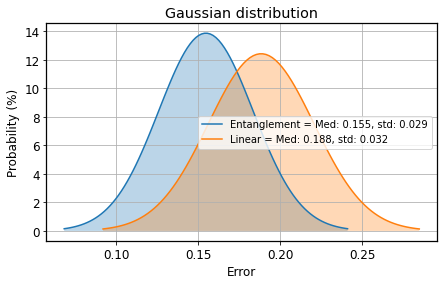

In [12]:
plt.rcParams["axes.edgecolor"] = "0.01"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['font.size'] = 12

plot_multiple_gaussian_distributions([error_ent_1024, error_linear_1024])

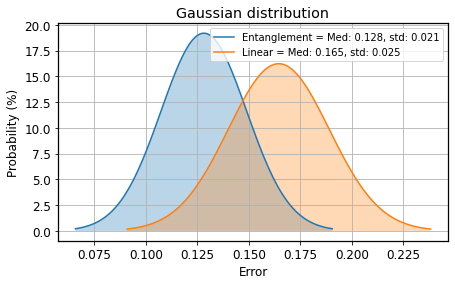

In [13]:
plot_multiple_gaussian_distributions([error_ent_2048, error_linear_2048])

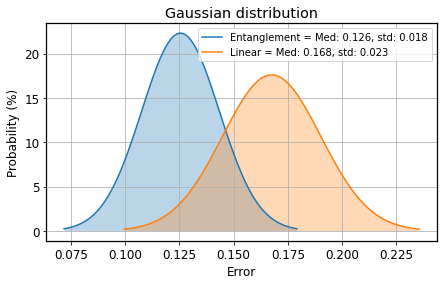

In [14]:
plot_multiple_gaussian_distributions([error_ent_4096, error_linear_4096])

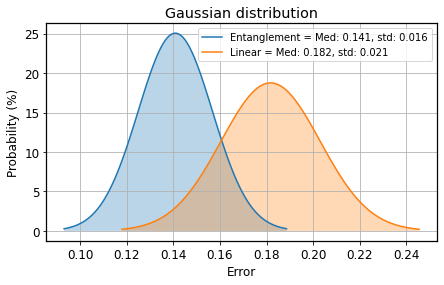

In [15]:
plot_multiple_gaussian_distributions([error_ent_8192, error_linear_8192])

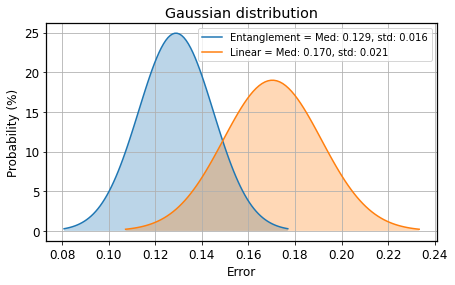

In [16]:
plot_multiple_gaussian_distributions([error_ent_16384, error_linear_16384])

The two gaussians are slowly moving apart from each other. Let's calculate what are the differents from the 1024 with the 16384 shots.

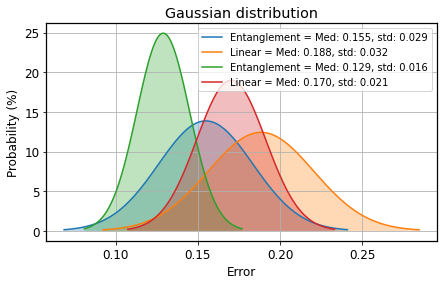

In [17]:
plot_multiple_gaussian_distributions([error_ent_1024, error_linear_1024, error_ent_16384, error_linear_16384])

This shows that increasing the values of the shots will move the gaussians. Let's study what is the correct of shots for not changing the gaussian too much.

In [93]:
titles = [1024, 2048, 4196, 8192, 16384, 131072]

def plot_3x2_gaussian_distributions(list_of_list_of_values):

    fig, axs = plt.subplots(2, 3, figsize=(14, 8))
    fig.suptitle('Gaussian Distributions for linear coupling and entanglement-aware coupling')

    for i, ax in enumerate(axs.flat):
        if i < len(list_of_list_of_values):
            values = list_of_list_of_values[i]

            colors = ['#191970',  '#FFD700']

            for j, value_set in enumerate(values):
                mean = np.mean(value_set)
                std_dev = np.std(value_set)
                x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
                y = stats.norm.pdf(x, mean, std_dev)

                color = colors[j % len(colors)]

                ax.plot(x, y, label=f'Mean: {mean:.3f}, Desv. Est.: {std_dev:.3f}', color = color)
                ax.fill_between(x, y, alpha=0.3, color = color)
            
            ax.set_xlim([0.05,0.3])
            ax.set_ylim([0, 35])
            ax.legend()
            ax.set_title(f'Gaussian Distribution for shots = {titles[i]}')
            ax.set_xlabel("Error")
            ax.set_ylabel("Probability (%)")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

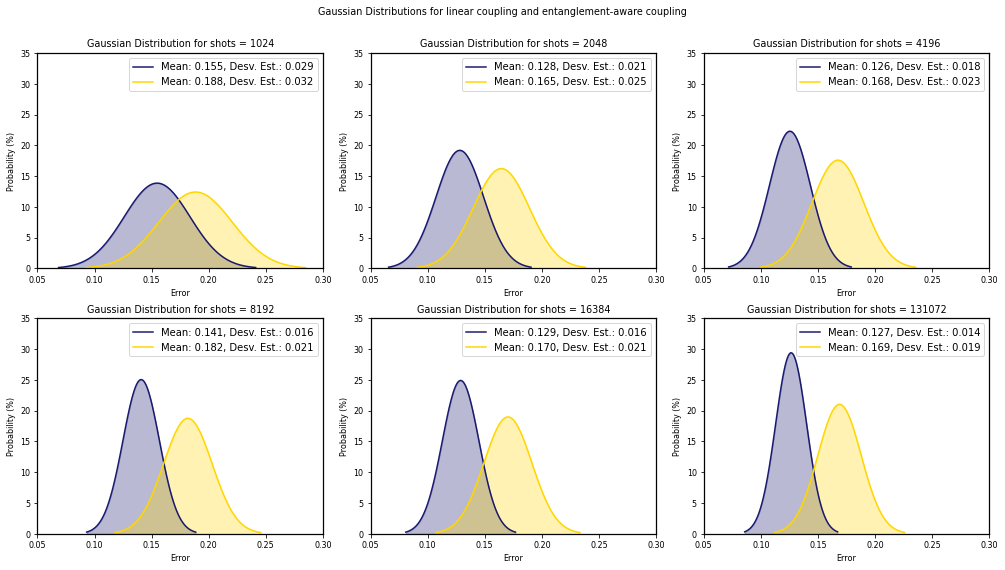

In [94]:
listas_para_graficar = [
    [error_ent_1024, error_linear_1024],
    [error_ent_2048, error_linear_2048],
    [error_ent_4096, error_linear_4096],
    [error_ent_8192, error_linear_8192],
    [error_ent_16384, error_linear_16384],
    [error_ent_131072, error_linear_131072]
]

plot_3x2_gaussian_distributions(listas_para_graficar)

From the previous graph we can see that the optimun value for the shots is the 16384 that is the lowest in shots and the closest to the shape of the 131072 shots.

# Others Coupling Maps

Now, let's study the performance of others coupling maps. Compare with the ones that are entanglement aware.

In [74]:
def mean_std(values):
    mean = np.mean(values)
    std_dev = np.std(values)
    return mean, std_dev

In [75]:
# Define all the possible coupling map with permutations.
element_permutations = permutations([0, 1, 2, 3, 4, 5])

def create_coupling_map(permutation):
    return [[permutation[i], permutation[i+1]] for i in range(len(permutation)-1)]

coupling_maps = [create_coupling_map(p) for p in element_permutations]
coupling_maps[:5], len(coupling_maps)

([[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5]],
  [[0, 1], [1, 2], [2, 3], [3, 5], [5, 4]],
  [[0, 1], [1, 2], [2, 4], [4, 3], [3, 5]],
  [[0, 1], [1, 2], [2, 4], [4, 5], [5, 3]],
  [[0, 1], [1, 2], [2, 5], [5, 3], [3, 4]]],
 720)

In [76]:
# Simulate all the possible coupling maps at 16384 shots.

mean_std_dict = []
samples = 3 # 1000
shots = 1024 # 16384

for i in range(0, len(coupling_maps[:2])): # Here you need to run all the coupling maps.
    error_cmaps = []
    print("Executing coupling map: {}".format(i))
    for j in range(0, samples):
        qc_exec = qc.copy()
        noise_dict = noise_simulation(True, qc_exec, measure_qubits, shots, coupling_maps[i])
        error_cmaps.append(error(real_dict, noise_dict , shots))
    
    mean_std_dict.append(mean_std(error_cmaps))

Executing coupling map: 0
Executing coupling map: 1


In [77]:
[[3, 0], [0, 4], [4, 5], [5, 2], [2, 1]] == coupling_maps[377]

True

In [78]:
mean_std_dict_total = np.load("Data/cmap_total.npy")

In [79]:
len(mean_std_dict_total)

720

In [80]:
def plot_points_with_error_area(data):

    means = [item[0] for item in data]
    std_devs = [item[1] for item in data]

    x_points = np.linspace(1, 720, len(data))

    error_upper = np.array(means) + np.array(std_devs)
    error_lower = np.array(means) - np.array(std_devs)

    plt.figure(figsize=(20, 5))

    plt.plot(x_points, means, 'o', label='Mean')

    plt.fill_between(x_points, error_lower, error_upper, color='gray', alpha=0.4)

    plt.title('Error Area for shots = 16384')
    plt.xlabel('Coupling Map')
    plt.ylabel('Mean')
    plt.xlim([0,720])
    plt.grid()
    plt.legend()
    plt.show()

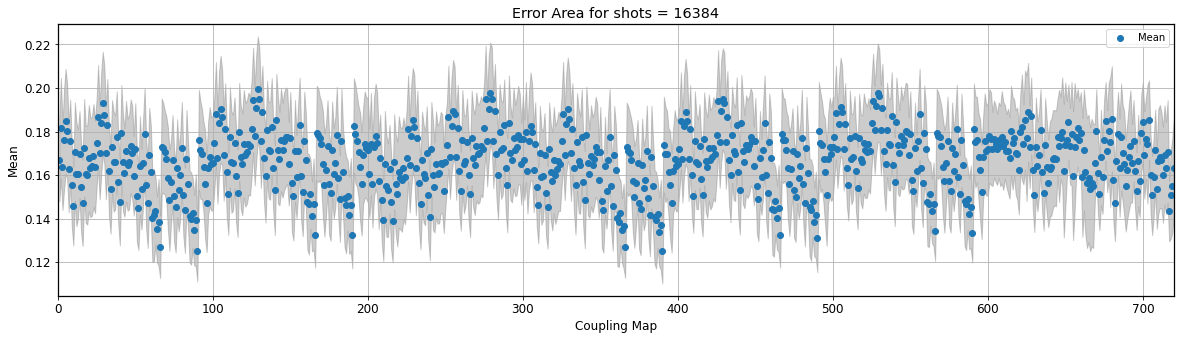

In [81]:
plot_points_with_error_area(mean_std_dict_total)

In [95]:
def plot_points_with_error_bars_and_threshold(data, threshold, negative):

    means = [item[0] for item in data]
    std_devs = [item[1] for item in data]

    x_points = np.arange(1, len(data) + 1)

    error_upper = np.array(means) + np.array(std_devs)
    error_lower = np.array(means) - np.array(std_devs)

    indices_below_threshold = []
    indices_above_threshold = []

    plt.figure(figsize=(20, 5))

    plt.fill_between(x_points, error_lower, error_upper, color='gray', alpha=0.5)

    for x, mean in zip(x_points, means):
        if mean < threshold:
            color = 'green'
            indices_below_threshold.append(x - 1)
        elif mean > negative:
            color = 'red'
            indices_above_threshold.append(x - 1)
        else:
            color = 'blue'

        plt.plot(x, mean, 'o', color=color, markersize=4)

    plt.title('Mean error for all possible coupling maps for 6 qubits circuit.')
    plt.xlabel('Coupling Map')
    plt.ylabel('Mean Error')
    plt.xlim([0,720])

    plt.show()

    return indices_below_threshold, indices_above_threshold

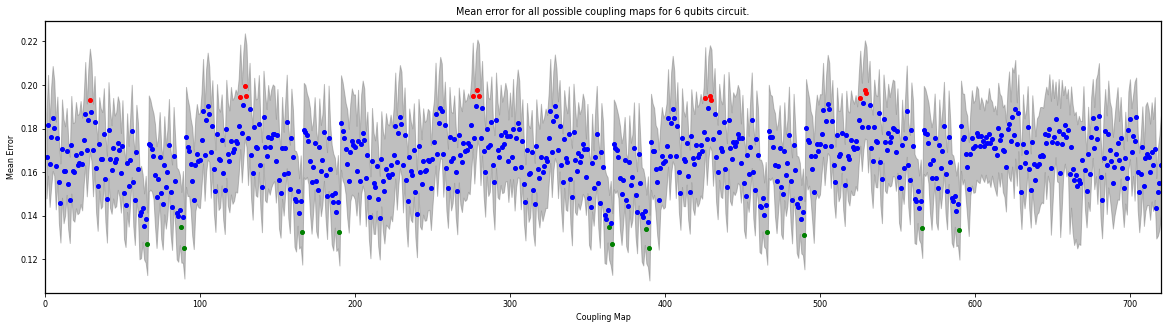

In [96]:
plt.rcParams['font.size'] = 8
index, index_bad = plot_points_with_error_bars_and_threshold(mean_std_dict_total, 0.135, 0.192) # 0.135, 0.192

In [84]:
print("Number of index with low errors = {}".format(len(index)))
print("Number of index with high errors = {}".format(len(index_bad)))

Number of index with low errors = 13
Number of index with high errors = 13


In [97]:
from IPython.display import display, Math

def display_matrix_latex(matrix):
    latex_str = r'\begin{pmatrix}'

    rows, cols = matrix.shape
    for i in range(rows):
        row_str = ' & '.join(map(str, matrix[i]))
        latex_str += row_str
        if i < rows - 1:
            latex_str += r'\\'

    latex_str += r'\end{pmatrix}'

    display(Math(latex_str))

In [98]:
display_matrix_latex(cmap_matrix)

<IPython.core.display.Math object>

In [99]:
def sum_coupling_values(matrix, coupling_map):
    """
    Calculate the sum of values in a matrix based on the indices provided by the coupling map.
    
    :param matrix: A 2D list representing the matrix.
    :param coupling_map: A list of pairs representing the indices in the matrix.
    :return: The sum of values at the specified indices in the matrix.
    """
    sum_val = 0
    for i, j in coupling_map:
        sum_val += matrix[i][j]
    return sum_val

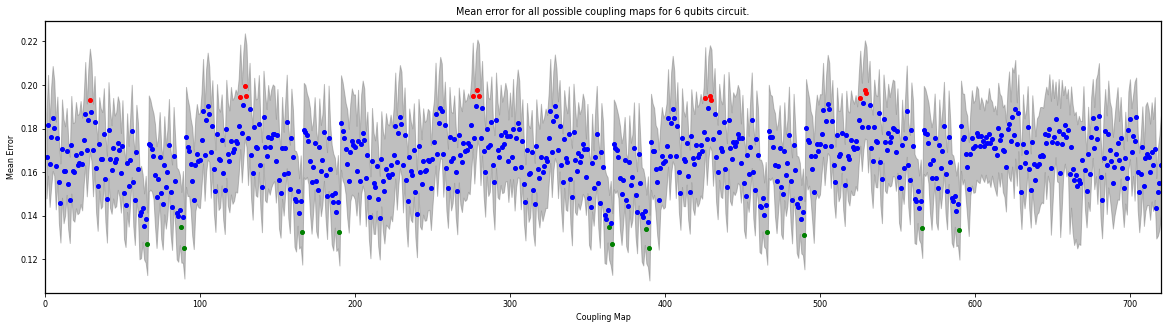

In [100]:
plt.rcParams['font.size'] = 8
index, index_bad = plot_points_with_error_bars_and_threshold(mean_std_dict_total, 0.135, 0.192) #89-200

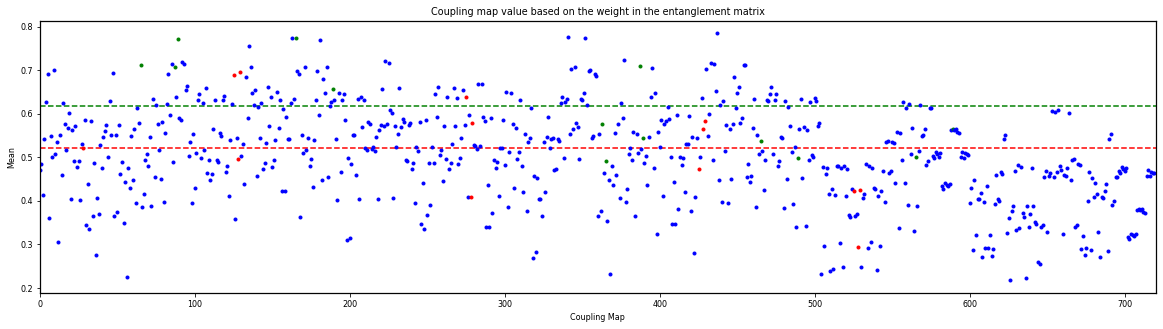

In [104]:
ent_values = []

for i in coupling_maps:
    ent_values.append(sum_coupling_values(cmap_matrix, i))

plt.rcParams['font.size'] = 8
plt.figure(figsize=(20, 5))
x_points = range(0, len(mean_std_dict_total) + 1)

mean_possitive = []
mean_negative = []

for x, value in zip(x_points, ent_values):
    if x in index:
        color = 'green'
        mean_possitive.append(value)
    elif x in index_bad:
        color = 'red'
        mean_negative.append(value)
    else:
        color = 'blue'
    
    plt.plot(x, value, 'o', color=color, markersize=3)

plt.hlines(np.mean(mean_possitive),xmin=0,xmax=720, colors='green', linestyles='dashed')
plt.hlines(np.mean(mean_negative),xmin=0,xmax=720, colors='red', linestyles='dashed')

plt.title('Coupling map value based on the weight in the entanglement matrix')
plt.xlabel('Coupling Map')
plt.ylabel('Mean')
plt.xlim([0,720])
plt.show()